# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

##  The dataset is for 105754 campaigns - telemarketing phone calls to sell long term deposits.  The data is from May 2008 to June 2013,  in total of 52944 phone contacts.  The results are either the client choose to buy the long term desposit- 'yes' or not buy 'no'. There are total 41188 rows and 21 columns

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [43]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from scipy.sparse import issparse
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
Bank_full_add = pd.read_csv('data//bank-additional-full.csv', sep = ';')

In [3]:
Bank_full_add.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [38]:
## Check if there are any Null value
print(Bank_full_add.isnull().sum())
## Check total compaigns
print(Bank_full_add['campaign'].sum())

## Check how many rows and columns in the origianl data
print(Bank_full_add.shape)

## List of columns to check for 'unknown' values and remove the "unknown" rows
columns_to_check = ['job','marital','education','default','loan']
Bank_full_clean = Bank_full_add[~Bank_full_add[columns_to_check].isin(['unknown']).any(axis=1)]

# Check the total # of rows after cleaning
Bank_full_clean.shape

# Drop duration column for better predictive model
Bank_full_clean = Bank_full_clean.drop('duration', axis=1)


# Pre-process the data by converting all objects to numerical and scale the numerical columns.  
# Build a column converter
col_transformer = make_column_transformer((OneHotEncoder(drop ='if_binary'),make_column_selector(dtype_include=object)),
                                         (StandardScaler(),make_column_selector(dtype_include=np.number)))

# Display the clean dataframe
print (Bank_full_clean.shape)
Bank_full_clean.head()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64
105754
(41188, 21)
(30488, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [5]:
## The goal is to compare 4 models to predict if the client would sign up long term CD or not and select the best model for prediciton.
##Assign all features to X, and client decision to y
X = Bank_full_clean.drop ('y', axis =1)
y= Bank_full_clean ['y']
print(type(X))
X.head()

<class 'pandas.core.frame.DataFrame'>


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [6]:
# Transform the X  with Col_transformer 
X_tr= col_transformer.fit_transform (X)
print (type(X_tr))

# Get the column names from the transformers
cat_columns = col_transformer.named_transformers_['onehotencoder'].get_feature_names_out(X.select_dtypes(include=object).columns)
num_columns =X.select_dtypes(include=np.number).columns
# Combine the column names
new_columns = list(cat_columns) + list(num_columns)
print(len(new_columns))

<class 'numpy.ndarray'>
52


In [7]:
# Transform y with labelencoder
## Encode the target variable y
le = LabelEncoder()
y_tr = le.fit_transform(y)

# Get the class mapping of target variable y
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class mapping:", class_mapping)

Class mapping: {'no': 0, 'yes': 1}


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [8]:
# Split the dataset into training and testing sets
# Covert X_tr to dataframe
X_tr_df = pd.DataFrame(X_tr, columns = new_columns)
X_train, X_test, y_train, y_test = train_test_split(X_tr_df, y_tr, test_size=0.2, random_state=42)
X_train.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_success,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
8688,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.293226,-0.559335,0.211887,-0.371616,0.913770,0.674261,-0.438017,0.845747,0.895282
13165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,-0.099678,-0.559335,0.211887,-0.371616,0.913770,-0.135490,0.940092,0.847435,0.895282
22731,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.158383,-0.191702,0.211887,1.541237,-1.073347,-1.076784,-1.168832,-1.200166,-0.821128
11038,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.545479,-0.559335,0.211887,-0.371616,0.913770,0.674261,-0.438017,0.845184,0.895282
19696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.384191,-0.559335,0.211887,-0.371616,-1.073347,-0.765867,-1.356756,-1.121953,-0.821128


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [9]:
## use dummyclassifier to establish the baseline
# Create a dummy classifier that predicts the most frequent class

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred_train = dummy_clf.predict(X_train)
y_pred_test = dummy_clf.predict(X_test)

# Calculate accuracy
train_accuracy=accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Baseline  train accuracy (most frequent class): {train_accuracy:.2f}")
print(f"Baseline test accuracy (most frequent class): {test_accuracy: .2f}")


Baseline  train accuracy (most frequent class): 0.87
Baseline test accuracy (most frequent class):  0.87


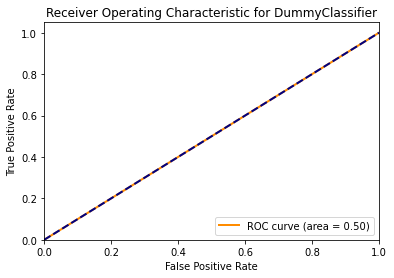

In [44]:
## Visualize ROC plots


# Assuming y_test and y_pred_test are defined
fpr, tpr, _ = roc_curve(y_test, dummy_clf.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, dummy_clf.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for DummyClassifier')
plt.legend(loc="lower right")
plt.show()

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [46]:
## Use logistic regression with "balanced" class_weight.  and search the 
lg = LogisticRegression(max_iter=1000)
lg.fit(X_train,y_train)
y_pred_test = lg.predict(X_test)
y_pred_train = lg.predict(X_train)


### Problem 9: Score the Model

What is the accuracy of your model?

train accuracy: 0.890
test accuracy: 0.886
Average fit time: 0.1727 seconds


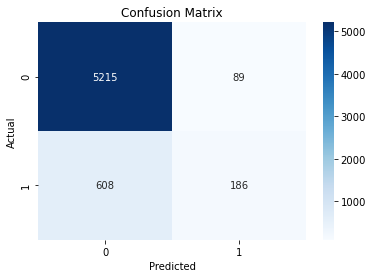

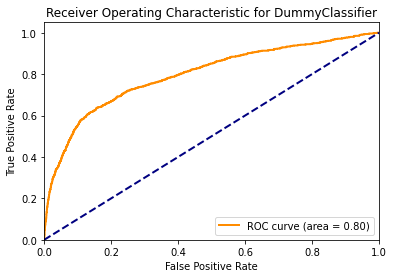

In [47]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train,y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"train accuracy: {train_accuracy:.3f}")
print(f"test accuracy: {test_accuracy:.3f}")

# Perform cross-validation and measure fit time
cv_results = cross_validate(lg, X_train, y_train, cv=3, return_train_score=False, scoring='accuracy')

# Extract fit times
fit_times = cv_results['fit_time']
# Calculate average fit time
average_fit_time = np.mean(fit_times)
print(f'Average fit time: {average_fit_time:.4f} seconds')

## Generate confusion matrix with sns
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Visualize ROC plots

fpr, tpr, _ = roc_curve(y_test, lg.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, lg.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LogisticRegression')
plt.legend(loc="lower right")
plt.show()

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

train accuracy: 0.90
test accuracy: 0.87
Average fit time: 0.0064 seconds


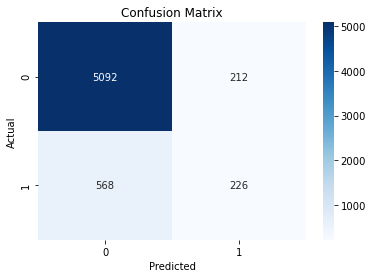

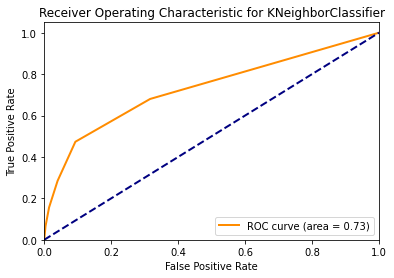

In [48]:
## KNN model
# Initialize the KNN classifier
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred_test = knn.predict(X_test)
y_pred_train = knn.predict(X_train)

# Calculate accuracy
train_accuracy = accuracy_score(y_train,y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"train accuracy: {train_accuracy:.2f}")
print(f"test accuracy: {test_accuracy:.2f}")

# Perform cross-validation and measure fit time
cv_results = cross_validate(knn, X_train, y_train, cv=3, return_train_score=False, scoring='accuracy')

# Extract fit times
fit_times = cv_results['fit_time']
# Calculate average fit time
average_fit_time = np.mean(fit_times)
print(f'Average fit time: {average_fit_time:.4f} seconds')

## Generate confusion matrix with sns
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Visualize ROC plots


fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for KNeighborClassifier')
plt.legend(loc="lower right")
plt.show()

train accuracy: 0.99
test accuracy: 0.82
Average fit time: 0.1042 seconds


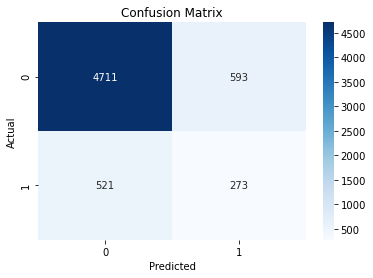

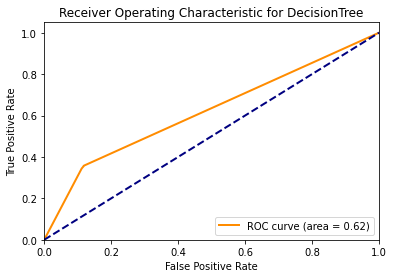

In [50]:
## Decision tree model
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred_test = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

# Calculate accuracy
train_accuracy = accuracy_score(y_train,y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"train accuracy: {train_accuracy:.2f}")
print(f"test accuracy: {test_accuracy:.2f}")

# Perform cross-validation and measure fit time
cv_results = cross_validate(dt, X_train, y_train, cv=3, return_train_score=False, scoring='accuracy')

# Extract fit times
fit_times = cv_results['fit_time']
# Calculate average fit time
average_fit_time = np.mean(fit_times)
print(f'Average fit time: {average_fit_time:.4f} seconds')

## Generate confusion matrix with sns
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Visualize ROC plots


fpr, tpr, _ = roc_curve(y_test, dt.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for DecisionTree')
plt.legend(loc="lower right")
plt.show()

train accuracy: 0.90
test accuracy: 0.89
Average fit time: 51.6925 seconds


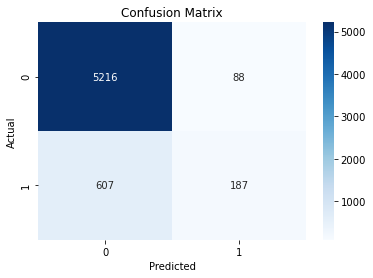

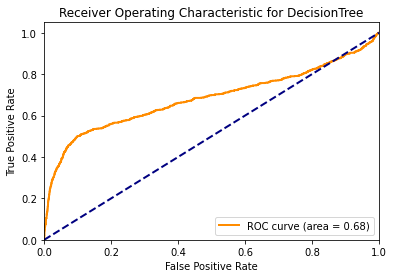

In [52]:
##SVC model
svc= SVC(probability=True)
svc.fit(X_train,y_train)
y_pred_test = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

# Calculate accuracy
train_accuracy = accuracy_score(y_train,y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"train accuracy: {train_accuracy:.2f}")
print(f"test accuracy: {test_accuracy:.2f}")

# Perform cross-validation and measure fit time
cv_results = cross_validate(svc, X_train, y_train, cv=3, return_train_score=False, scoring='accuracy')

# Extract fit times
fit_times = cv_results['fit_time']
# Calculate average fit time
average_fit_time = np.mean(fit_times)
print(f'Average fit time: {average_fit_time:.4f} seconds')

## Generate confusion matrix with sns
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Visualize with ROC
fpr, tpr, _ = roc_curve(y_test, svc.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for DecisionTree')
plt.legend(loc="lower right")
plt.show()


In [53]:
results_df = ''

    
# construct a dictionary with all 4 models
res_dict={'model':['Logistic Regression','KNN','Decision Tree','SVC'],
         'train score':[0.89,0.90,0.99,0.90],
         'test score':[0.89,0.87,0.82,0.89],
         'average fit time':[0.1856,0.0063,0.1045,51.6925]}
results_df =pd.DataFrame(res_dict).set_index('model')

### ANSWER CHECK
print(type(results_df))
print(results_df.shape)
results_df.head()

<class 'pandas.core.frame.DataFrame'>
(4, 3)


,train score,test score,average fit time
model,,,
Logistic Regression,0.89,0.89,0.1856
KNN,0.90,0.87,0.0063
Decision Tree,0.99,0.82,0.1045
SVC,0.90,0.89,51.6925


## Logistic regression performs the best with simple model comparison

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [10]:
## Use Sequential Feature Selector to check which feature should be included
from sklearn.feature_selection import SequentialFeatureSelector
import time


In [12]:
## Use logistic regression and search with Sequential Feature selection to see which features should be included
lg = LogisticRegression(max_iter=1000)

# Initialize the Sequential Feature Selector and set tol to 0.00001.
sfs = SequentialFeatureSelector(lg, n_features_to_select ='auto', tol=0.00001,direction='forward', cv=3)

# Fit the selector to the data
sfs.fit(X_train, y_train)

# Get the selected features
selected_features = sfs.get_support(indices=True)
selected_feature_names = X_train.columns[selected_features]
print(f"Selected feature names with tol = 0.00001: {selected_feature_names}")

## Set the tol = 0.01 to compare the time used for SFS selections with other models.
## tol is to set the boundary that only features affecting the accuracy >=0.01.

# Initialize the Sequential Feature Selector and set tol to 0..01.
sfs = SequentialFeatureSelector(lg, n_features_to_select ='auto', tol=0.01,direction='forward', cv=3)

# Fit the selector to the data
# Measure the time taken for feature selection
start_time = time.time()
sfs.fit(X_train, y_train)
end_time = time.time()
sfs.fit(X_train, y_train)

# Get the selected features
selected_features = sfs.get_support(indices=True)
selected_feature_names = X_train.columns[selected_features]
print(f"Selected feature names with tol = 0.01: {selected_feature_names}")

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken for Sequential Feature Selection: {elapsed_time:.2f} seconds")

Selected feature names with tol = 0.00001: Index(['job_entrepreneur', 'job_housemaid', 'education_basic.9y',
       'education_high.school', 'contact_telephone', 'month_jul', 'month_mar',
       'day_of_week_fri', 'poutcome_failure', 'poutcome_success', 'campaign',
       'nr.employed'],
      dtype='object')
Selected feature names with tol = 0.01: Index(['poutcome_success'], dtype='object')
Time taken for Sequential Feature Selection: 6.02 seconds


In [13]:
# Transform the training and test data to include only the selected features
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

# Re-fit the logistic regression model using the selected features
lg.fit(X_train_selected, y_train)

y_pred_test = lg.predict(X_test_selected)
y_pred_train = lg.predict(X_train_selected)
# Evaluate the model
# Calculate accuracy
train_accuracy = accuracy_score(y_train,y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"train accuracy: {train_accuracy:.3f}")
print(f"test accuracy: {test_accuracy:.3f}")


train accuracy: 0.887
test accuracy: 0.880


In [14]:
# Define the parameter grid for GridSearchCV to optimize logisticRegression
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear'], 
  }

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the selected features
grid_search.fit(X_train_selected, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Re-fit the logistic regression model using the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_selected, y_train)

# predict 
y_pred_test = best_model.predict(X_test_selected)
y_pred_train = best_model.predict(X_train_selected)
# Evaluate the model
#accuracy = best_model.score(X_test_selected, y_test)
#print(f"Model accuracy with selected features and optimized hyperparameters: {accuracy}")

# Calculate accuracy
train_accuracy = accuracy_score(y_train,y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"train accuracy: {train_accuracy:.3f}")
print(f"test accuracy: {test_accuracy:.3f}")

Best parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.8867978679786799
train accuracy: 0.887
test accuracy: 0.880


In [15]:
## Use KNN and search with Sequential Feature selection to see which features should be included
knn = KNeighborsClassifier()
# Initialize the Sequential Feature Selector and set tol to 0.01
sfs = SequentialFeatureSelector(knn, n_features_to_select ='auto', tol=0.01,direction='forward', cv=3)
# Measure the time taken for feature selection
start_time = time.time()
sfs.fit(X_train, y_train)
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken for Sequential Feature Selection: {elapsed_time:.2f} seconds")

# Get the selected features
selected_features = sfs.get_support(indices=True)
selected_feature_names = X_train.columns[selected_features]
print(f"Selected feature names: {selected_feature_names}")



Time taken for Sequential Feature Selection: 266.67 seconds
Selected feature names: Index(['pdays'], dtype='object')


In [16]:
# Transform the training and test data to include only the selected features
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

# Re-fit the logistic regression model using the selected features
knn.fit(X_train_selected, y_train)

y_pred_test = knn.predict(X_test_selected)
y_pred_train = knn.predict(X_train_selected)
# Evaluate the model
# Calculate accuracy
train_accuracy = accuracy_score(y_train,y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"train accuracy: {train_accuracy:.3f}")
print(f"test accuracy: {test_accuracy:.3f}")

train accuracy: 0.887
test accuracy: 0.880


In [17]:
## Use GridsearchCV with KNN to optimize the model

knn = KNeighborsClassifier()

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
# Fit the model
grid_search.fit(X_train_selected, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Re-fit the logistic regression model using the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_selected, y_train)

# predict 
y_pred_test = best_model.predict(X_test_selected)
y_pred_train = best_model.predict(X_train_selected)
# Evaluate the model
#accuracy = best_model.score(X_test_selected, y_test)
#print(f"Model accuracy with selected features and optimized hyperparameters: {accuracy}")

# Calculate accuracy
train_accuracy = accuracy_score(y_train,y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"train accuracy: {train_accuracy:.3f}")
print(f"test accuracy: {test_accuracy:.3f}")

Best parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Best cross-validation score: 0.8867568675686757
train accuracy: 0.887
test accuracy: 0.881


In [41]:
## Use  decision tree and search with Sequential Feature selection to see which features should be included
dt = DecisionTreeClassifier()
# Initialize the Sequential Feature Selector and set tol to 0.01
sfs = SequentialFeatureSelector(dt, n_features_to_select ='auto', tol=0.01,direction='forward', cv=3)
# Measure the time taken for feature selection
start_time = time.time()
sfs.fit(X_train, y_train)
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken for Sequential Feature Selection: {elapsed_time:.2f} seconds")

# Get the selected features
selected_features = sfs.get_support(indices=True)
selected_feature_names = X_train.columns[selected_features]
print(f"Selected feature names: {selected_feature_names}")


Time taken for Sequential Feature Selection: 1.71 seconds
Selected feature names: Index(['poutcome_success', 'nr.employed'], dtype='object')


In [42]:
# Transform the training and test data to include only the selected features
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

# Re-fit the  decision tree model using the selected features
dt.fit(X_train_selected, y_train)

y_pred_test = dt.predict(X_test_selected)
y_pred_train = dt.predict(X_train_selected)
# Evaluate the model
# Calculate accuracy
train_accuracy = accuracy_score(y_train,y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"train accuracy: {train_accuracy:.3f}")
print(f"test accuracy: {test_accuracy:.3f}")

train accuracy: 0.889
test accuracy: 0.882


In [43]:
## Use GridsearchCV with KNN to optimize the model

dt = DecisionTreeClassifier()

# Define the parameter grid
# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
# Fit the model
grid_search.fit(X_train_selected, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Re-fit the logistic regression model using the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_selected, y_train)

# predict 
y_pred_test = best_model.predict(X_test_selected)
y_pred_train = best_model.predict(X_train_selected)
# Evaluate the model
#accuracy = best_model.score(X_test_selected, y_test)
#print(f"Model accuracy with selected features and optimized hyperparameters: {accuracy}")

# Calculate accuracy
train_accuracy = accuracy_score(y_train,y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"train accuracy: {train_accuracy:.3f}")
print(f"test accuracy: {test_accuracy:.3f}")

Best parameters: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best cross-validation score: 0.8886838868388685
train accuracy: 0.889
test accuracy: 0.882


In [ ]:
## Use  SVM  and search with Sequential Feature selection to see which features should be included
svc =SVC()
# Initialize the Sequential Feature Selector and set tol to 0.01
sfs = SequentialFeatureSelector(svc, n_features_to_select ='auto', tol=0.01,direction='forward', cv=3)
# Measure the time taken for feature selection
start_time = time.time()
sfs.fit(X_train, y_train)
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken for Sequential Feature Selection: {elapsed_time:.2f} seconds")

# Get the selected features
selected_features = sfs.get_support(indices=True)
selected_feature_names = X_train.columns[selected_features]
print(f"Selected feature names: {selected_feature_names}")

In [22]:

## Due to the long SFS seaching time, use other agorithm's search results ['poutcome_success', 'nr.employed']

X_train_selected = X_train[['poutcome_success', 'nr.employed']]
X_test_selected = X_test[['poutcome_success', 'nr.employed']]

#Define SVC param_grid
svc_param_grid = {'C': [0.1, 1, 10, 100]}

# GridSearchCV
grid_svc = GridSearchCV(svc, param_grid=svc_param_grid, cv =3,scoring='accuracy' )
grid_svc.fit(X_train_selected,y_train)

# Predict the test set
y_pred_svc = grid_svc.predict(X_test_selected)

# Print the best parameters and best score
print(f'Best parameters: {grid_svc.best_params_}')
print(f'Best cross-validation accuracy: {grid_svc.best_score_:.2f}')

# Perform cross-validation and measure fit time
cv_results = cross_validate(grid_svc, X_train_selected, y_train, cv=3, return_train_score=False, n_jobs=-1, scoring='accuracy', return_estimator=False)

# Extract fit times
fit_times = cv_results['fit_time']

# Calculate average fit time
average_fit_time = np.mean(fit_times)
print(f'Average fit time: {average_fit_time:.4f} seconds')

# Calculate the train score
train_score = grid_svc.score(X_train_selected, y_train)
print(f'Train score: {train_score:.2f}')

# Calculate the test score
test_score = grid_svc.score(X_test_selected, y_test)
print(f'Test score: {test_score:.2f}')

Best parameters: {'C': 1}
Best cross-validation accuracy: 0.89
Average fit time: 44.5080 seconds
Train score: 0.89
Test score: 0.88


In [40]:
results_df = ''

    
# construct a dictionary with all 4 models
res_dict={'model':['Logistic Regression','KNN','Decision Tree','SVC'],
         'train score':[0.89,0.89,0.89,0.89],
         'test score':[0.88,0.88,0.88,0.88],
         'SFS search time':[6.02,266.67,1.71,">600"]}
results_df =pd.DataFrame(res_dict).set_index('model')

### ANSWER CHECK
print(type(results_df))
print(results_df.shape)
results_df.head()

<class 'pandas.core.frame.DataFrame'>
(4, 3)


,train score,test score,SFS search time
model,,,
Logistic Regression,0.89,0.88,6.02
KNN,0.89,0.88,266.67
Decision Tree,0.89,0.88,1.71
SVC,0.89,0.88,>600


##### Questions